# 연구과제 풀이

## 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

import re

## 문제 1

### (1) 위스콘신 유방암 데이터 셋

#### 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"])

<class 'pandas.core.frame.DataFrame'>
Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   diagnosis                569 non-null    category
 1   radius_mean              569 non-null    float64 
 2   texture_mean             569 non-null    float64 
 3   perimeter_mean           569 non-null    float64 
 4   area_mean                569 non-null    float64 
 5   smoothness_mean          569 non-null    float64 
 6   compactness_mean         569 non-null    float64 
 7   concavity_mean           569 non-null    float64 
 8   concave points_mean      569 non-null    float64 
 9   symmetry_mean            569 non-null    float64 
 10  fractal_dimension_mean   569 non-null    float64 
 11  radius_se                569 non-null    float64 
 12  texture_se               569 non-null    float64 
 13  perimeter_se             569 non-null    float64 
 14  area_se 

#### 데이터 전처리

1. 종속변수 라벨링
2. 데이터 분할 + 데이터 스케일링
3. 데이터 불균형 해소 (SMOTE)

In [3]:
df1 = my_labelling(origin, 'diagnosis')

x_train, x_test, y_train, y_test = my_train_test_split(df1, 'diagnosis', scalling=True)

xdata, ydata = my_balance(x_train, y_train, method="smote")

#### KNN 분류

[교차검증]
+----+-----------+---------------+-----------+-------------------+
|    | metric    |   n_neighbors | weights   |   mean_test_score |
|----+-----------+---------------+-----------+-------------------|
|  3 | euclidean |             5 | distance  |          0.977193 |
|  7 | manhattan |             3 | distance  |          0.973669 |
| 11 | manhattan |             7 | distance  |          0.973669 |
|  5 | euclidean |             7 | distance  |          0.971914 |
|  6 | manhattan |             3 | uniform   |          0.971899 |
|  2 | euclidean |             5 | uniform   |          0.970144 |
|  9 | manhattan |             5 | distance  |          0.968406 |
|  1 | euclidean |             3 | distance  |           0.96662 |
|  4 | euclidean |             7 | uniform   |          0.964866 |
| 10 | manhattan |             7 | uniform   |           0.96485 |
|  0 | euclidean |             3 | uniform   |           0.96308 |
|  8 | manhattan |             5 | uniform   |         

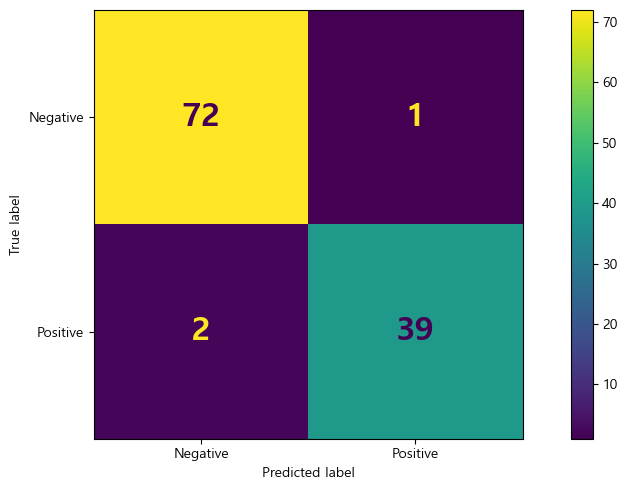

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


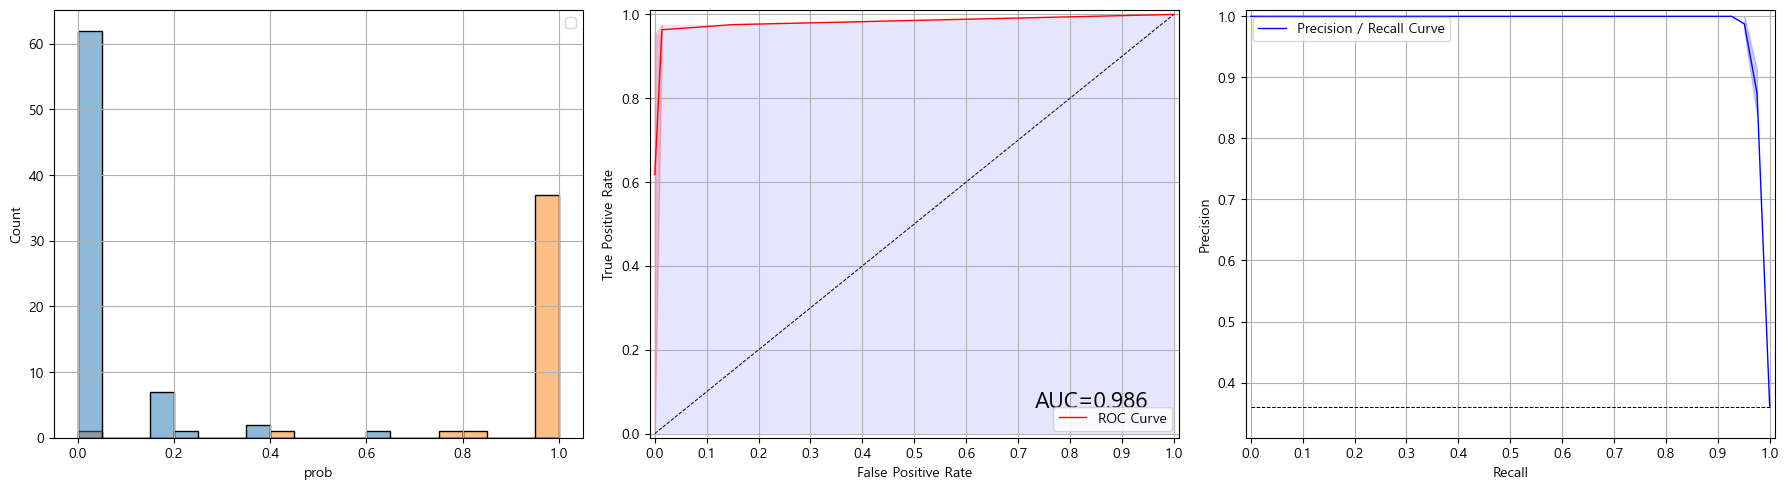


[학습곡선]


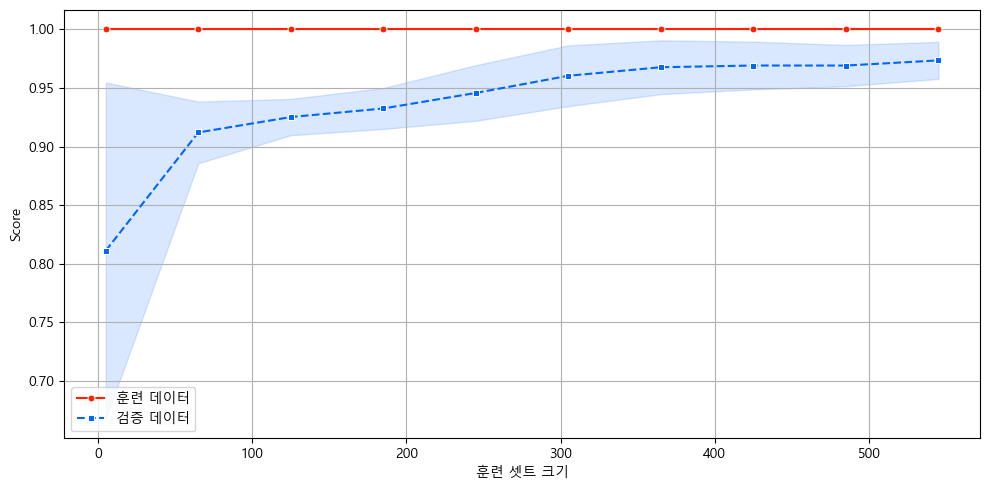

KNeighborsClassifier(metric='euclidean', n_jobs=-1, weights='distance')

In [4]:
my_knn_classification(xdata, ydata, x_test, y_test)

> 로지스틱 분석을 수행한 경우 정확도 `99%`, 재현률 `97%` 였으나 KNN은 정확도 `97%`, 재현률 `95%`를 보였다.
>
> 그러므로 이 데이터는 로지스틱 회귀가 KNN보다 더 좋은 성능을 보인다고 할 수 있다.

### (2) 타이타닉 생존률 예측

#### 데이터 가져오기

In [5]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

#### 데이터 전처리

1. 생존 여부에 따른 평균 나이로 결측치 치환
2. 히스토그램 구간에 따라 나이를 명목형으로 변환
3. 객실 유무에 따른 명목형 변수 생성
4. 가족 구성원 수 파생변수 생성
5. 혼자 탑승했는지에 대한 파생변수 생성
6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
8. 이름으로부터 호칭 파생변수 생성
9. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거

In [6]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 |     0 |     2 |      3 |          0 |           1 |            2 |         0 |       3 |
|             3 |          1 |        3 |     0 |     1 |      1 |          2 |           0 |            1 |         1 |       1 |
|             4 |          1 |        1 |     0 |     2 |      3 |          2 |           1 |            2 |         0 |       3 |
|             5 |          0 |        3 |     1 |     2 |      1 |          2 |    

#### 훈련/검증 데이터 분리

In [7]:
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

#### KNN 분류

[교차검증]
+----+-----------+---------------+-----------+-------------------+
|    | metric    |   n_neighbors | weights   |   mean_test_score |
|----+-----------+---------------+-----------+-------------------|
|  8 | manhattan |             5 | uniform   |          0.842411 |
| 10 | manhattan |             7 | uniform   |          0.836687 |
|  6 | manhattan |             3 | uniform   |          0.835721 |
|  2 | euclidean |             5 | uniform   |          0.831902 |
| 11 | manhattan |             7 | distance  |          0.829979 |
|  4 | euclidean |             7 | uniform   |          0.829032 |
|  9 | manhattan |             5 | distance  |          0.829018 |
|  7 | manhattan |             3 | distance  |           0.82807 |
|  5 | euclidean |             7 | distance  |          0.825186 |
|  0 | euclidean |             3 | uniform   |          0.824261 |
|  3 | euclidean |             5 | distance  |          0.824242 |
|  1 | euclidean |             3 | distance  |         

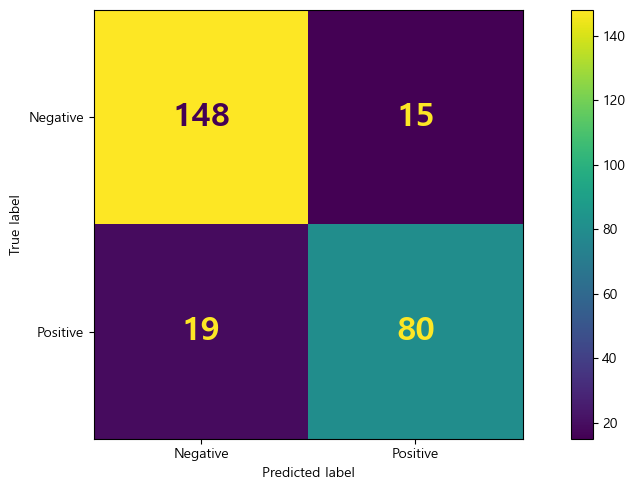

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


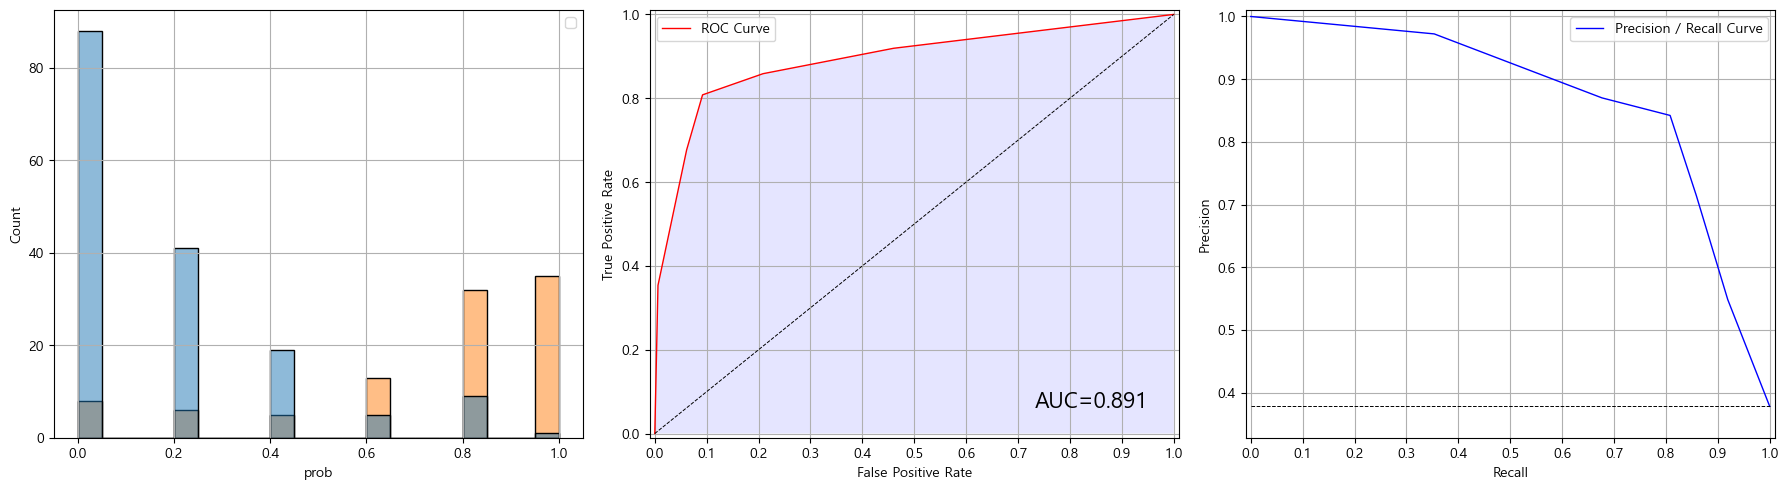


[학습곡선]


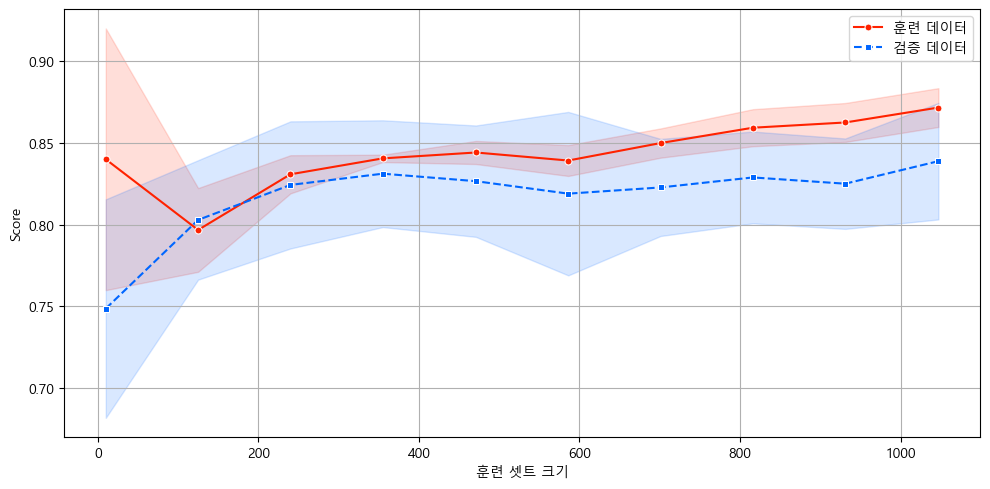

KNeighborsClassifier(metric='manhattan', n_jobs=-1)

In [8]:
my_knn_classification(x_train, y_train, x_test, y_test)

> 로지스틱 분석의 경우 86.6%의 정확도와 82.7%의 정밀도를 보이는 반면 KNN은 87%의 정확도와 84.2%의 정밀도를 보인다.
> 
> 그러므로 타이타닉 생존률 예측의 경우 KNN 분류가 더 좋은 성능을 보인다.